***

# AutoRec
- 사용자의 아이템별 평점 또는 아이템의 사용자별 평점 벡터에 대하여 Auto Encoder 방식으로, input을 output으로 재현하는 방식으로 평점을 예측하는 기법


### - Reference: [AutoRec: Autoencoders Meet Collaborative Filtering](https://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf)

### - Prediction:
아이템 i에 대한 사용자들의 평점 벡터 $r^{(i)}$는 아래와 같이 예측
<center> $r^{(i)}=f(W \cdot g(Vr+\mu)+b)$ </center>

|expression|mean|
|:---:|:---:|
|$$r^{(i)} = (r_{1i}, ..., r_{ui})$$|아이템 i에 대한 사용자들의 평점 벡터|
|$W$|디코더 레이어|
|$V$|인코더 레이어|
|$$h(\cdot), g(\cdot)$$|인코더, 디코더 레이어의 활성화 함수. sigmoid, relu 등이 사용될 수 있음|
|$\mu, b$|인코더, 디코더 레이어의 bias|

### - Optimization:
아래의 목적함수를 최소화 하는 파라미터를 추정함
<center> $min_{\theta}\sum_{i\in (1,...,n)}||r - r^{(i)}||^2_O + (\lambda/2)(||W||^2_{Frod}+||V||^2_{Frod})$ </center>

|expression|mean|
|:---:|:---:|
|$O$|관측된 평점에 대하여 계산한다는 의미|

관측되지 않은 평점에 대하여, 논문에서는 평점을 3으로 대체하였음</br>
네트워크의 backward 연산은 관측된 평점에 대해서만 수행함
    
### - Evaluation:
|split|measure|
|:---:|:---:|
|holdout|RMSE|

***

## Import library

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from Generator.MatrixGenerator import MatrixGenerator
from Models.AutoRec import AutoRec

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

***

## 1) Data processing

### load data

In [2]:
ratings = pd.read_csv('../data/movie_lens/ratings.csv',
                      names=['user_id', 'item_id', 'rating', '_'],
                      skiprows=1).drop(columns=['_'])
ratings

,user_id,item_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


### convert id to index

In [3]:
user_ids = ratings['user_id'].unique().tolist()
item_ids = ratings['item_id'].unique().tolist()

num_user = len(user_ids)
num_item = len(item_ids)

id_to_index_user = {user_ids[i] :i for i in range(num_user)}
id_to_index_item = {item_ids[i] :i for i in range(num_item)}

ratings['user_id'] = ratings['user_id'].apply(lambda x: id_to_index_user[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: id_to_index_item[x])

ratings

,user_id,item_id,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0
...,...,...,...
100831,609,3120,4.0
100832,609,2035,5.0
100833,609,3121,5.0
100834,609,1392,5.0


### split data

In [4]:
val_ratio = 0.1
test_ratio = 0.2
seed = 1234

train, others = train_test_split(ratings,
                                 test_size=val_ratio+test_ratio,
                                 shuffle=True,
                                 random_state=seed)

validation, test = train_test_split(others,
                                    test_size=test_ratio/(val_ratio+test_ratio),
                                    shuffle=True,
                                    random_state=seed)

print(f"# of observation(train/val/test): {len(train)}, {len(validation)}, {len(test)}")

# of observation(train/val/test): 70585, 10083, 20168


### set config & get dataset from generator

In [5]:
class DatasetConfig:
    num_negative = 0
    batch = 128

dataset_config = DatasetConfig()

In [7]:
dataset = MatrixGenerator(train_data=train,
                          n_user=num_user,
                          n_item=num_item,
                          config=dataset_config)

### see example data for a batch

In [8]:
train_loader = DataLoader(dataset, batch_size=2)
_, data1, data2 = next(iter(train_loader))

(1) [ [$rating_{u,1}$, ..., $rating_{u, m}$] X batch_size]

In [9]:
data1

tensor([[0., 4., 4.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

(2) [ [$implicit_{u,1}$, ..., $implicit_{u, m}$] X batch_size]

In [10]:
data2

tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

note. m: # of item

***

## 2) Modeling

### set config & get model

In [11]:
class OptimizerConfig:
    method = 'Adam'
    regulation = 1e-5
    learning_rate = 0.01
    learning_decay = 0.95

class ModelConfig:
    epochs = 30
    print_step = 5

class AutoRecConfig:
    evaluation = 'MSE'
    dim_latent = 300
    fill_na_as = 3.0

optimizer_config = OptimizerConfig()
autorec_config = AutoRecConfig()
model_config = ModelConfig()

In [12]:
inputs = {"n_user":num_user,
          "n_item":num_item}

model = AutoRec(inputs, model_config, optimizer_config, autorec_config)

[BaseModel] method = Adam
[BaseModel] regulation = 1e-05
[BaseModel] learning_rate = 0.01
[BaseModel] learning_rate_decay = 0.95


### fit model & see loss and performance

In [13]:
train_loader = DataLoader(dataset, batch_size=dataset_config.batch)
model.fit(train_loader=train_loader, val_data=validation)


[AutoRec]============================================== Train ===============================================
[AutoRec]           (train: MSE)        (validation: MSE)   
          (epoch 5) 0.8340              1.4756              
         (epoch 10) 0.7744              1.4387              
         (epoch 15) 0.7653              1.4342              
         (epoch 20) 0.7599              1.4378              
         (epoch 25) 0.7563              1.4347              
         (epoch 30) 0.7539              1.4349              


***

## 3) Evaluation

### evaluate testset

In [14]:
model.test(train_loader=train_loader, test_data=test)


[AutoRec]============================================= Evaluate =============================================
[AutoRec] (test: MSE) = 1.4709


### see plot for loss and performance

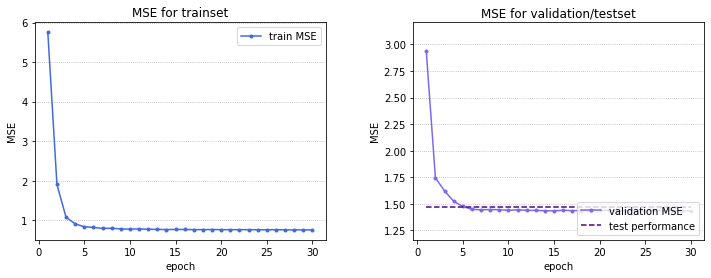

In [15]:
figure = model.draw_plot()
plt.show()